In [1]:
import keypress_recognition.models as models
from keypress_recognition import dataset_p as dataset
import numpy as np
import matplotlib.pyplot as plt
import cv2
%load_ext autoreload
%autoreload 2

In [2]:
concat = False
delta = 3 if concat else 1
channels = 3 * delta

In [6]:
bmodel = models.get_black_key_model(channels)

RuntimeError: CUDA error: unknown error

In [3]:
dataset.load_all_data(color=['black'], size=['single'], keypress=True, concatenate=concat, delta=delta)

Start seperating keyboard ...
  White single width: 21px
  Black single width: 20px
  White bundle width: 37px
  Black bundle width: 36px


IntProgress(value=0, max=14273)

In trainset: 
  # of pressed black key: 8755
  # of unpressed black key: 43833


IntProgress(value=0, max=5000)

In testset: 
  # of pressed black key: 761
  # of unpressed black key: 22515


IntProgress(value=0, max=2993)

In valset: 
  # of pressed black key: 817
  # of unpressed black key: 10887


In [4]:
def visualize_keys(note):
    """
    note: bool
    return: str
    """
    return ("Y" if note else "N")

def display_concat_img(img, idx=None):
    if concat:
        if idx is None:
            return img[:, :, :, 3:6]
        else:
            return img[idx, :, :, 3:6]
    if idx is None:
        return img
    else:
        return img[idx, :, :, :]


Samples from X_train: 


IntProgress(value=0, max=87666)

(2, 106, 20, 3)
1 0
Samples from X_test: 


IntProgress(value=0, max=45030)

(2, 106, 20, 3)
1 0
Samples from X_val: 


IntProgress(value=0, max=21774)

(2, 106, 20, 3)
1 0


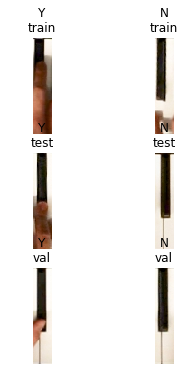

In [5]:
# print several images with labels
fig, axarr = plt.subplots(3, 2, figsize=[4, 6])
for ii, _type in enumerate(['train', 'test', 'val']):

    print(f'Samples from X_{_type}: ')

    for imgb, noteb in dataset.data_batch(type=_type, size='single', color='black', batch_size=2, NCHW=False, need_velocity=False, concatenate=concat):
        print(imgb.shape)
        print(noteb[0], noteb[1])
        axarr[ii,0].imshow(cv2.cvtColor(display_concat_img(imgb, 0), cv2.COLOR_BGR2RGB))
        axarr[ii,0].set_title(visualize_keys(noteb[0]) + '\n' + _type)
        axarr[ii,0].axis('off')
        axarr[ii,1].imshow(cv2.cvtColor(display_concat_img(imgb, 1), cv2.COLOR_BGR2RGB))
        axarr[ii,1].set_title(visualize_keys(noteb[1]) + '\n' + _type)
        axarr[ii,1].axis('off')
        break

plt.show()

In [ ]:
bmodel.train(dataset, batch_size=32, size='single', color='black',
             concatenate=concat,
             num_epochs=20,
             max_num=-1,
             learning_rate=1e-4,
             best_path='keypress_recognition/best_black_model.tar',
             current_path='keypress_recognition/current_black.tar',
             method=0)

In [ ]:
example_batch = 12
fig, axarr = plt.subplots(1, example_batch, figsize=(15,4))
for imgb, noteb in dataset.data_batch(type='test', size='single', color='black', batch_size=example_batch, NCHW=True, need_velocity=False, concatenate=concat):
    yb = bmodel.evaluate(imgb, threshold=0.5)
    imgb = np.transpose(imgb, (0, 2, 3, 1))
    print(imgb.shape)
    print(yb)
    for i in range(example_batch):
        axarr[i].imshow(cv2.cvtColor(display_concat_img(imgb, i), cv2.COLOR_BGR2RGB))
        axarr[i].set_title('Truth: ' + visualize_keys(noteb[i]) + '\nPred:  ' + visualize_keys(yb[i]))
        axarr[i].axis('off')
    break
plt.show()

In [5]:
import torch
torch.cuda.empty_cache()
torch.cuda.set_device("cuda:0")
m = torch.nn.Sequential()